# DKTC Test

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re

from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training

import transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, DistilBertForSequenceClassification, AdamW
from transformers import pipeline

from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [34]:
!pip install matplotlib seaborn

In [2]:
# 한글 깨짐 방지

import platform

os = platform.system()

# Windows
if os == 'Windows':
    plt.rc('font', family= 'Malgun Gothic')

# Mac
elif os == 'Darwin':
    plt.rc('font', family= 'AppleGothic')

# Linux
elif os == 'Linux':
    plt.rc('font', family= 'NanumGothic')

else:
    print(f'{os} is not set')

### 데이터 로드 및 전처리
1. 형태소 분석기
2. 불용어 리스트
3. 구두점 처리

In [3]:
train_data_path ="/aiffel/aiffel/aiffel_dlthon_c2/data/aug_train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,Unnamed: 0,idx,class,conversation
0,0,0,협박 대화,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,1,협박 대화,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,2,기타 괴롭힘 대화,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,3,갈취 대화,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,4,갈취 대화,피부가 따끔거리네요.


In [4]:
train_data = train_data.drop(train_data.columns[0], axis=1)

In [5]:
train_data.head()

,idx,class,conversation
0,0,협박 대화,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,협박 대화,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,기타 괴롭힘 대화,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,갈취 대화,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,갈취 대화,피부가 따끔거리네요.


In [6]:
train_data['conversation'].head(5)

0                            네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1             "길동 경찰서입니다" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야.
2    왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3    너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4                                          피부가 따끔거리네요.
Name: conversation, dtype: object

In [7]:
data = train_data.copy()

In [8]:
test_data_path ="/aiffel/aiffel/aiffel_dlthon_c2/data/test.csv"
test_data = pd.read_csv(test_data_path)
test_data.head(5)

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [9]:
test = test_data.copy()

In [10]:
len(data)

33496

In [11]:
len(test)

500

In [12]:
# 열 이름 변경
data = data.rename(columns={'class': 'class_label'})
data

,idx,class_label,conversation
0,0,협박 대화,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,협박 대화,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,기타 괴롭힘 대화,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,갈취 대화,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,갈취 대화,피부가 따끔거리네요.
...,...,...,...
33491,33491,기타 괴롭힘 대화,왜 나한테 이러는 거야? 왜 그렇게 무식한데 머리가 이렇게 큰 거야? 그냥 멍청한 ...
33492,33492,갈취 대화,네. 선생님 진정하시고 우리 스스로의 말로 해결합시다.
33493,33493,직장 내 괴롭힘 대화,"""예""라고 제대로 말하고 그렇게 정확하게 대답하는 걸 본 적이 없어."
33494,33494,갈취 대화,내가 줄 수 없어. 우리 구역이니까 우리가 하고 싶은 대로 할 수 있어 좋은 말을 ...


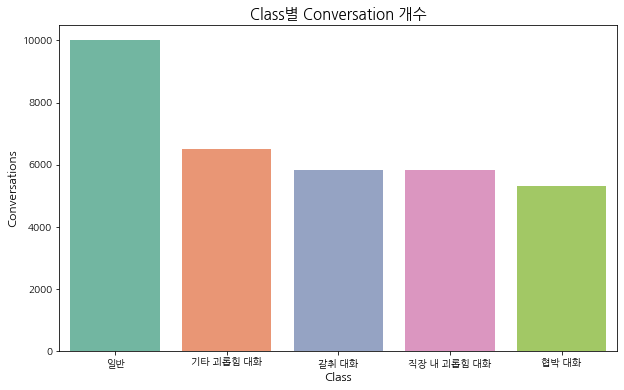

In [13]:
# 데이터 분포 시각화

class_counts = data['class_label'].value_counts().reset_index()
class_counts.columns = ['class_label', 'count']  # 컬럼 이름 설정

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='class_label', y='count', data=class_counts, palette='Set2')

plt.title('Class별 Conversation 개수', fontsize=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Conversations', fontsize=12)
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반']

label_size = len(CLASS_NAMES)

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

data['class_label'] = encoder.transform(data['class_label'])
data.head()

,idx,class_label,conversation
0,0,4,네가 선택해 네 가족을 죽여줄까? 죄송합니다.
1,1,4,"""길동 경찰서입니다"" 9시 40분 마트에 폭발물이 터지면 다 죽는 거야."
2,2,1,왜 그래? 지영아 네가 키 160이지? 그럼 재는 160도 안 되는 거네? 너 군대...
3,3,0,너 옷 좋아 보인다? 얘 돈 좀 있나 봐 아니에요. 돈 없어요 뒤져서 나오면 넌 죽...
4,4,0,피부가 따끔거리네요.


In [15]:
from sklearn.preprocessing import LabelEncoder

# train 데이터셋의 'class_label' 컬럼을 라벨 인코딩
label_encoder = LabelEncoder()

# 'class_label' 열에 인코딩을 적용하여 숫자로 변환
data['class_label'] = label_encoder.fit_transform(data['class_label'])

# 변환된 데이터 확인
print(data['class_label'].head())

0    4
1    4
2    1
3    0
4    0
Name: class_label, dtype: int64


In [13]:
group_counts = data['class_label'].value_counts()                                                                                                                                                                         
number_min_label = min(group_counts)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 896


In [16]:
# 각 클래스의 개수를 출력
group_counts = data['class_label'].value_counts()

print("각 클래스의 개수:")
print(group_counts)

각 클래스의 개수:
2    9999
1    6509
0    5842
3    5819
4    5327
Name: class_label, dtype: int64


In [14]:
data = data.groupby("class_label").sample(number_min_label, random_state = 200)
data.groupby("class_label").count().iloc[:,0]

class_label
갈취 대화          896
기타 괴롭힘 대화      896
일반             896
직장 내 괴롭힘 대화    896
협박 대화          896
Name: idx, dtype: int64

In [17]:
group_counts = data['class_label'].value_counts()
number_min_label = min(group_counts)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 5327


In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 60
print(MAX_LENGTH)

400


In [18]:
data = data.groupby("class_label").sample(number_min_label, random_state = 200)
data.groupby("class_label").count().iloc[:,0]

class_label
0    5327
1    5327
2    5327
3    5327
4    5327
Name: idx, dtype: int64

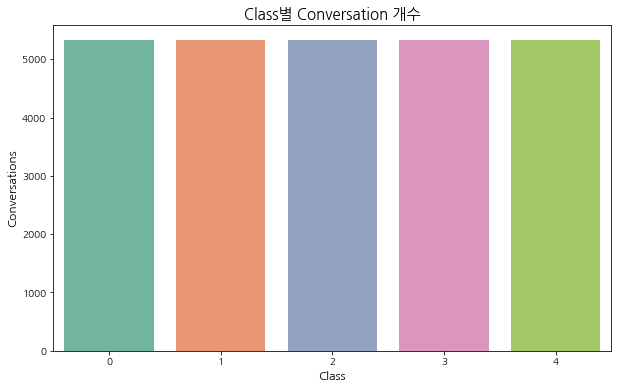

In [36]:
# 데이터 분포 시각화

class_counts = data['class_label'].value_counts().reset_index()
class_counts.columns = ['class_label', 'count']  # 컬럼 이름 설정

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='class_label', y='count', data=class_counts, palette='Set2')

plt.title('Class별 Conversation 개수', fontsize=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Conversations', fontsize=12)
plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 사용해 라벨을 숫자로 변환
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(data['class_label'].tolist())

### KLUE/BERT 모델 토크나이저

In [20]:
!nvidia-smi

Mon Oct  7 14:02:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0              28W /  70W |   3939MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [21]:
# GPU 설정 (가능할 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# KLUE-BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=len(data['class_label'].unique()))  # 클래스 수에 맞게 설정
model.to(device)

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [26]:
print(data['class_label'][1],"\n")

4 



In [27]:
# 라벨을 정수형으로 변환 (수정된 부분)
label_mapping = {label: idx for idx, label in enumerate(data['class_label'].unique())}  # 라벨을 정수형으로 변환
data['class_label'] = data['class_label'].map(label_mapping)  # 라

In [28]:
# 데이터셋 클래스 정의 (토크나이징과 데이터 로드)
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        item = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        # 라벨이 있는 경우, 정수형 라벨을 사용하도록 수정 (수정된 부분)
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # 라벨은 정수형으로 변환됨

        return item

In [30]:
# 훈련 및 테스트 데이터 준비
train_texts = data['conversation'].tolist()
train_labels = data['class_label'].tolist()

test_texts = test['text'].tolist()  # 라벨 없이 텍스트만 사용
# test_labels는 테스트 데이터에 없으므로 None으로 설정

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [31]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [32]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    total = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total += len(labels)
        losses.append(loss.item())

    return correct_predictions.double() / total, np.mean(losses)

In [33]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            if 'labels' in batch:
                true_labels.extend(batch['labels'].cpu().numpy())

    return predictions, true_labels

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

EPOCHS = 10

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')

    # 마지막 에포크에서만 혼동행렬 생성
    if epoch == EPOCHS - 1:
        # 테스트 데이터에서 예측값 추출 및 F1 Score 계산
        predictions, true_labels = evaluate(model, test_loader, device)

        # F1 Score 계산 (테스트 데이터의 라벨이 있는 경우)
        if true_labels:
            f1 = f1_score(true_labels, predictions, average='weighted')
            print(f'F1 Score: {f1}')
            
            # 혼동행렬 계산 및 시각화
            conf_matrix = confusion_matrix(true_labels, predictions)
            
            # 그래프 시각화
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()
        else:
            print("Test data predictions:", predictions)


Epoch 1/10
Train loss: 0.7166941410741648, Train accuracy: 0.7412427257368124
Epoch 2/10
Train loss: 0.33205121478049066, Train accuracy: 0.886352543645579
Epoch 3/10
Train loss: 0.18824584181462456, Train accuracy: 0.9350103247606532
Epoch 4/10
Train loss: 0.1349201565692285, Train accuracy: 0.9520555659846066
Epoch 5/10
Train loss: 0.11611423989343275, Train accuracy: 0.9593016707339965
Epoch 6/10
Train loss: 0.09898200004774792, Train accuracy: 0.9641449220949877
Epoch 7/10
Train loss: 0.09122751595864251, Train accuracy: 0.968274826356298
Epoch 8/10
Train loss: 0.0884267588069819, Train accuracy: 0.9688755397033977
Epoch 9/10
Train loss: 0.07685808637483582, Train accuracy: 0.9718040172705087
Epoch 10/10
Train loss: 0.074814725518765, Train accuracy: 0.9739440585695512
Test data predictions: [0, 3, 3, 1, 1, 4, 4, 2, 1, 0, 4, 1, 3, 3, 3, 4, 1, 1, 4, 1, 4, 1, 1, 0, 0, 3, 1, 1, 3, 0, 0, 4, 1, 0, 4, 1, 1, 0, 4, 0, 4, 0, 3, 0, 1, 3, 4, 1, 1, 4, 0, 1, 0, 3, 3, 1, 1, 1, 1, 1, 0, 4, 2, 1, 

In [40]:
submission = pd.DataFrame({
    'idx': test['idx'],  # 테스트 데이터의 idx 열 사용
    'target': predictions  # 모델 예측 결과 사용
})

submission.to_csv('submission.csv', index=False)  # CSV 파일로 저장

In [47]:
!pip install streamlit
!pip install --upgrade typing_extensions
!pip install --upgrade transformers torch
!pip install typing_extensions==4.5.0

  Using cached transformers-4.45.1-py3-none-any.whl (9.9 MB)
     |████████████████████████████████| 797.1 MB 4.2 kB/s              
     |████████████████████████████████| 436 kB 43.2 MB/s            
     |████████████████████████████████| 436 kB 48.1 MB/s            
     |████████████████████████████████| 2.9 MB 54.4 MB/s            
     |████████████████████████████████| 209.4 MB 37 kB/s              
     |████████████████████████████████| 409.6 MB 89.6 MB/s eta 0:00:01     |████████████████████████████████| 410.6 MB 2.3 kB/s             
     |████████████████████████████████| 121.6 MB 14 kB/s               
     |████████████████████████████████| 6.2 MB 50.9 MB/s            
     |████████████████████████████████| 124.2 MB 12 kB/s              
     |████████████████████████████████| 823 kB 56.9 MB/s            
     |████████████████████████████████| 99 kB 11.2 MB/s            
     |████████████████████████████████| 196.0 MB 20 kB/s              
     |██████████████████████

In [50]:
!pip install --upgrade typing_extensions

In [51]:
!pip install --upgrade transformers datasets

     |████████████████████████████████| 471 kB 4.6 MB/s            
     |████████████████████████████████| 78 kB 10.1 MB/s            
     |████████████████████████████████| 64 kB 5.7 MB/s             
     |████████████████████████████████| 177 kB 86.0 MB/s            
     |████████████████████████████████| 39.9 MB 62.1 MB/s            
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1
  Attempting uninstall: datase

In [52]:
!pip install typing_extensions==4.5.0

  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.12.2
    Uninstalling typing-extensions-4.12.2:
      Successfully uninstalled typing-extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.4.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.5.0 which is incompatible.
altair 5.4.1 requires typing-extensions>=4.10.0; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.


In [55]:
!pip install typing_extensions

In [57]:
from flask import Flask, request, jsonify
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from threading import Thread

# Flask 앱 생성
app = Flask(__name__)

# 장치 설정 (CUDA가 가능하면 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# KLUE-BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=5)
model.to(device)
model.eval()

# 클래스 이름 정의
class_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

# 예측 API 엔드포인트 정의
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    text = data.get('text', '')

    if not text:
        return jsonify({"error": "No text provided"}), 400

    # 입력 텍스트 토큰화
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1)
        predicted_class = class_names[prediction.item()]

    # 예측된 클래스 반환
    return jsonify({"predicted_class": predicted_class})

# 백그라운드에서 Flask 서버 실행
def run_flask():
    app.run(host='0.0.0.0', port=5000)

# Flask 서버를 백그라운드에서 실행
flask_thread = Thread(target=run_flask)
flask_thread.start()


Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


2024-10-07 17:53:43.759 WARNING werkzeug:  * Running on all addresses.
2024-10-07 17:53:43.760 INFO    werkzeug:  * Running on http://10.84.95.9:5000/ (Press CTRL+C to quit)


In [58]:
# 모델 저장
model.save_pretrained("model_directory")
tokenizer.save_pretrained("model_directory")


('model_directory/tokenizer_config.json',
 'model_directory/special_tokens_map.json',
 'model_directory/vocab.txt',
 'model_directory/added_tokens.json')